In [1]:
from transformers import DESeq2RatioNormalizer, FeatureSelection2

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone

from joblib import Parallel, delayed
import itertools
import numpy as np
import pandas as pd

# Classifiers
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
from train_test import load_data, filter_data, encode_labels, conditional_f1
import pyarrow
X, y, study_labels = load_data("/Users/jsevere2/Library/CloudStorage/OneDrive-UMCUtrecht/AML/data/processed/prediction")
X, y, study_labels = filter_data(X, y, study_labels, min_n = 20)
y, label_mapping = encode_labels(y)



  studies_series: 2834
  X_df: (60660, 2834)
  y_series: 2834
  Studies: 2834
  X shape: (2834, 60660)
  y: 2834


  Studies: 2268
  X shape: (2268, 60660)
  y: 2268


In [7]:
from classifiers import NeuralNet

params = {
    'n_neurons': [800, 400, 200],  # three hidden layers
    'dropout_rate': 0.5,
    'batch_size': 32,
    'patience': 100,
    'l2_reg': 0.001,
    'validation_split': 0.2,
    'class_weight': True,
    'use_batch_norm': True,
    'min_delta': 0,
    'learning_rate': 0.0001
}


pipe = Pipeline([
    ('DEseq2', DESeq2RatioNormalizer()),
    ('feature_selection', FeatureSelection2()),
    ('scaler', StandardScaler())
])

In [4]:
X_mod = pipe.fit_transform(X=X,y=y, feature_selection__study_per_patient = study_labels, feature_selection__n_genes = 2000)

In [5]:
X_mod.shape

(2268, 479)

In [8]:
model = NeuralNet(**params)
model = model.fit(X_mod, y)  # will use validation_split from params


Epoch 1/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0896 - loss: 8.9668 - val_accuracy: 0.2004 - val_loss: 4.9532
Epoch 2/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1128 - loss: 7.8070 - val_accuracy: 0.2379 - val_loss: 4.2359
Epoch 3/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1257 - loss: 6.0249 - val_accuracy: 0.2511 - val_loss: 3.7725
Epoch 4/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1774 - loss: 5.1598 - val_accuracy: 0.3106 - val_loss: 3.4920
Epoch 5/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1923 - loss: 5.3235 - val_accuracy: 0.3150 - val_loss: 3.2585
Epoch 6/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1777 - loss: 4.8037 - val_accuracy: 0.3282 - val_loss: 3.1386
Epoch 7/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2255 - loss: 4.1625 - val_accuracy: 0.3238 - val_loss: 3.0579
Epoch 8/2000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2493 - loss: 4.4219 - val_accuracy: 0.

In [10]:
print(model.model.history.history.keys())
print(max(model.model.history.history['val_accuracy']))

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.8616188168525696


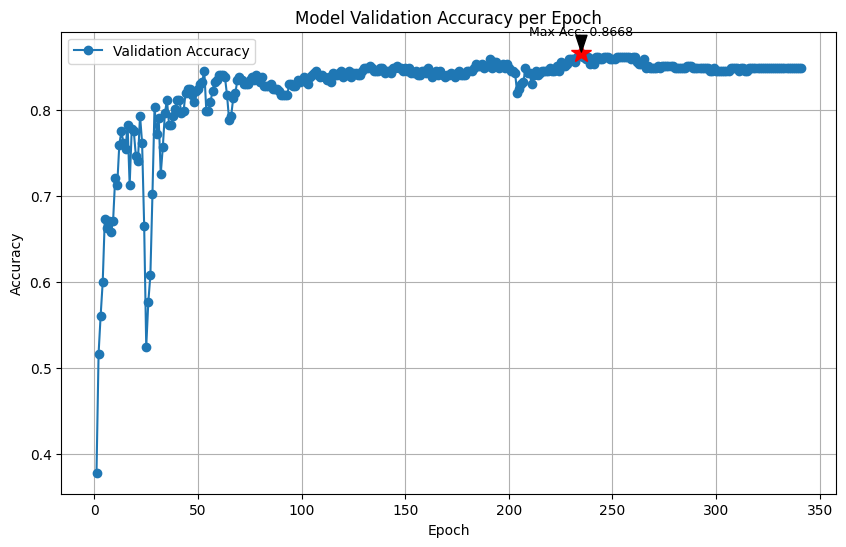

In [13]:
import matplotlib.pyplot as plt

# Access the training history - using 'val_accuracy' now
val_accuracy = model.model.history.history['val_accuracy']

# Create the x-axis values (epochs)
# Starts from 1 for better readability of epochs
xc = range(1, len(val_accuracy) + 1)

# Find the maximum accuracy and its corresponding epoch index
max_accuracy = max(val_accuracy)
# Get the index of the first occurrence of max_accuracy
max_index = val_accuracy.index(max_accuracy)
# Adjust index to epoch number (index + 1)
max_epoch = xc[max_index]

# --- Plotting ---
# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

# Plot the validation accuracy
ax.plot(xc, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-') # Changed label

# Add labels and title for clarity
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy') # Changed y-axis label
ax.set_title('Model Validation Accuracy per Epoch') # Changed title
ax.legend() # Show the legend
ax.grid(True) # Add a grid for easier reading

# --- Highlight the maximum accuracy ---
# Add an annotation for the maximum point
ax.annotate(f'Max Acc: {max_accuracy:.4f}', # Text to display (formatted to 4 decimal places)
            xy=(max_epoch, max_accuracy),    # Point to annotate (epoch, accuracy)
            xytext=(max_epoch, max_accuracy + 0.02), # Position of the text (slightly above the point)
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8), # Arrow properties
            fontsize=9,
            ha='center') # Horizontal alignment of the text

# Optionally, add a marker specifically for the max point
ax.plot(max_epoch, max_accuracy, marker='*', markersize=15, color='red', linestyle='', label=f'Max Accuracy ({max_accuracy:.4f}) at Epoch {max_epoch}')
# Update legend to include the max point marker (optional, can make legend busy)
# ax.legend()


# Display the plot
plt.show()


In [10]:
preds = model.predict(X_mod)
int_to_label = {v: k for k, v in label_mapping.items()}
[int_to_label[pred] for pred in preds]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


['AML with mutated TP53',
 'AML with MDS-related gene mutations',
 'AML with mutated NPM1',
 'APL, t(15;17)/PML::RARA',
 'AML with MDS-related gene mutations',
 'AML with mutated NPM1',
 'KMT2A::MLLT10',
 'AML with mutated TP53',
 'AML with MDS-related gene mutations',
 'AML with mutated NPM1',
 'AML with inv(3)/t(3;3)/GATA2;MECOM',
 'AML with MDS-related cytogenetic abnormalities',
 'AML with MDS-related gene mutations',
 'AML with MDS-related gene mutations',
 'APL, t(15;17)/PML::RARA',
 'AML with inv(16)/t(16;16)/CBFB::MYH11',
 'AML with MDS-related gene mutations',
 'AML with inv(16)/t(16;16)/CBFB::MYH11',
 'AML with mutated NPM1',
 'AML with inv(16)/t(16;16)/CBFB::MYH11',
 'AML with t(9;11)/MLLT3::KMT2A',
 'AML with mutated NPM1',
 'AML with t(9;11)/MLLT3::KMT2A',
 'AML with inv(16)/t(16;16)/CBFB::MYH11',
 'AML with MDS-related gene mutations',
 'AML with MDS-related gene mutations',
 'AML with t(9;11)/MLLT3::KMT2A',
 'AML with mutated TP53',
 'APL, t(15;17)/PML::RARA',
 'AML with

In [ ]:
studies_as_folds = [
        "BEATAML1.0-COHORT",
        "AAML0531",
        "AAML1031",
        "TCGA-LAML",
        "LEUCEGENE"
    ]

multi_type = "standard"
n_jobs = 12

import warnings
warnings.filterwarnings('always')


# Function to evaluate one inner fold + hyperparam combo



#for multi_type in ["standard", "OvO", "OvR"]:
#    df_parallel_results = run_inner_cv(X, y, study_labels, model, param_grid, n_jobs, multi_type = multi_type, k_out = 2, k_in = 2)

In [116]:
y_val_ij = [1,1,1,1, 1]
preds = [1,1,1,1, 1]
print(conditional_f1(y_val_ij, preds))
print(cohen_kappa_score(y_val_ij, preds))
print(matthews_corrcoef(y_val_ij, preds))

1.0
nan
0.0


/home/jeppe/Documents/Leukem.ai/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/jeppe/Documents/Leukem.ai/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/jeppe/Documents/Leukem.ai/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [68]:
def process_cv_results(df, param_grid, label_mapping, score_col):
    #  Extract param names and expand 'params'
    param_names = list(param_grid.keys())
    params_df = df['params'].apply(pd.Series)

    # Normalize None values for groupby
    for col in param_names:
        if col in params_df.columns:
            params_df[col] = params_df[col].apply(lambda x: 'none' if x is None else x)

    #Combine expanded params with original DataFrame
    df_with_params = pd.concat([df.drop(columns=['params']), params_df], axis=1)

    # Determine group-by strategy based on evaluation type
    if 'class' in df_with_params.columns:
        # OvR
        group_cols = param_names + ['class']
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[summary.groupby('class')[score_col].idxmax()].reset_index(drop=True)

    elif 'class_0' in df_with_params.columns and 'class_1' in df_with_params.columns:
        # OvO
        group_cols = param_names + ['class_0', 'class_1']
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[summary.groupby(['class_0', 'class_1'])[score_col].idxmax()].reset_index(drop=True)

    else:
        # Standard multiclass
        group_cols = param_names
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[[summary[score_col].idxmax()]].reset_index(drop=True)

    int_to_label = {v: k for k, v in label_mapping.items()}
    if 'class' in best.columns:
        # OvR case
        best['class_label'] = best['class'].map(int_to_label)
        return best

    elif 'class_0' in best.columns and 'class_1' in best.columns:
        # OvO case
        best['class_0_label'] = best['class_0'].map(int_to_label)
        best['class_1_label'] = best['class_1'].map(int_to_label)
        return best

    else:
        return best

best_per_class_df = process_cv_results(
    df_parallel_results,
    param_grid=param_grid,
    label_mapping = label_mapping,
    score_col = "kappa"
)
best_per_class_df["kappa"].mean()

np.float64(0.6709831404600013)

In [ ]:
import warnings
warnings.filterwarnings('ignore')



for multi_type in ["OvO"]:
    print(multi_type)
    df_parallel_results_study_as_fold = run_inner_cv_loso(X, y, study_labels, model, param_grid, n_jobs=12, multi_type=multi_type)
df_parallel_results_study_as_fold

OvO

--- Outer Loop: Holding out Study 'BEATAML1.0-COHORT' for Testing ---
Outer training set contains studies: ['AAML0531', 'AAML1031', 'LEUCEGENE', 'TCGA-LAML']
  Inner Loop: Validating on Study 'AAML0531'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '2'
classes '0' and '1'
classes '0' and '3'
classes '0' and '2'
classes '0' and '4'
classes '0' and '3'
classes '0' and '5'
classes '0' and '4'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '7'
classes '0' and '11'
classes '0' and '12'
classes '0' and '13'
classes '0' and '8'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '0' and '9'
classes '1' and '4'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '1' and '7'
classes '1' and '8'
classes '0' and '12'
classes '1' and '9'
classes '0' and '13'
classes '1' and '11'
classes '1' and '12'
classes '0' and '14'
classes '1' and '13'
classes '1' and '14'
classes '0' and '16'
classes '1' and '16'
classes '1' and '2'
classes '2' and '3'
classes '2' and '4'
classes '1' and '3'
classes '2' and '5'
classes '2' and '6'
classes '1' and '4'
classes '2' and '7'
class

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   16.5s finished


  Inner Loop: Validating on Study 'AAML1031'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '4'
classes '0' and '7'
classes '0' and '7'
classes '0' and '8'
classes '0' and '8'
classes '0' and '9'
classes '0' and '11'
classes '0' and '9'
classes '0' and '12'
classes '0' and '11'
classes '0' and '13'
classes '0' and '12'
classes '0' and '16'
classes '0' and '13'
classes '3' and '4'
classes '0' and '16'
classes '3' and '7'
classes '3' and '8'
classes '3' and '4'
classes '3' and '9'
classes '3' and '7'
classes '3' and '11'
classes '3' and '12'
classes '3' and '8'
classes '3' and '13'
classes '3' and '9'
classes '3' and '16'
classes '4' and '7'
classes '3' and '11'
classes '4' and '8'
classes '4' and '9'
classes '3' and '12'
classes '4' and '11'
classes '4' and '12'
classes '3' and '13'
classes '4' and '13'
classes '4' and '16'
classes '3' and '16'
classes '4' and '7'
classes '7' and '8'
classes '4' and '8'
classes '7' and '9'
classes '4' and '9'
classes '7' and '11'
classes '4' and '11'
classes '7' and '1

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '5'
classes '0' and '4'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '8'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '13'
classes '0' and '14'
classes '0' and '9'
classes '0' and '16'
classes '1' and '2'
classes '0' and '10'
classes '1' and '3'
classes '1' and '4'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '1' and '7'
classes '1' and '8'
classes '0' and '12'
classes '1' and '9'
classes '1' and '10'
classes '1' and '11'
classes '1' and '12'
classes '1' and '13'
classes '0' and '13'
classes '1' and '14'
classes '1' and '16'
classes '0' and '14'
classes '2' and '3'
classes '2' and '4'
classes '2' and '5'
classes '2' and '6'
classes '2' and '7'
classes '0' and '16'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   13.6s finished


  Inner Loop: Validating on Study 'TCGA-LAML'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '0' and '9'
classes '1' and '2'
classes '0' and '10'
classes '1' and '3'
classes '1' and '4'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '1' and '8'
classes '0' and '12'
classes '1' and '9'
classes '1' and '10'
classes '0' and '13'
classes '1' and '11'
classes '1' and '12'
classes '1' and '13'
classes '0' and '14'
classes '1' and '14'
classes '1' and '16'
classes '2' and '3'
classes '2' and '4'
classes '0' and '16'
classes '2' and '5'
classes '2' and '6'
classes '1' and '2'
classes '2' and '8'
classes '2' and '9'
classes '2' and '10'
c

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   15.2s finished


  Finished evaluations for outer fold 'BEATAML1.0-COHORT'.

--- Outer Loop: Holding out Study 'AAML0531' for Testing ---
Outer training set contains studies: ['AAML1031', 'BEATAML1.0-COHORT', 'LEUCEGENE', 'TCGA-LAML']
  Inner Loop: Validating on Study 'AAML1031'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '4'
classes '0' and '7'
classes '0' and '7'
classes '0' and '8'
classes '0' and '8'
classes '0' and '9'
classes '0' and '9'
classes '0' and '11'
classes '0' and '11'
classes '0' and '12'
classes '0' and '12'
classes '0' and '13'
classes '0' and '16'
classes '0' and '13'
classes '0' and '16'
classes '3' and '4'
classes '3' and '7'
classes '3' and '4'
classes '3' and '8'
classes '3' and '7'
classes '3' and '9'
classes '3' and '8'
classes '3' and '11'
classes '3' and '12'
classes '3' and '9'
classes '3' and '13'
classes '3' and '11'
classes '3' and '16'
classes '3' and '12'
classes '4' and '7'
classes '3' and '13'
classes '4' and '8'
classes '3' and '16'
classes '4' and '9'
classes '4' and '7'
classes '4' and '11'
classes '4' and '12'
classes '4' and '8'
classes '4' and '13'
classes '4' and '9'
classes '4' and '16'
classes '4' and '11'
classes '4' and '12'
classes '4' and '13'
classes '7' and '8'
classes '4' and '

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    2.6s finished


  Inner Loop: Validating on Study 'BEATAML1.0-COHORT'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '8'
classes '0' and '5'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '13'
classes '0' and '8'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '1' and '4'
classes '0' and '9'
classes '1' and '5'
classes '0' and '10'
classes '1' and '6'
classes '0' and '11'
classes '1' and '8'
classes '1' and '9'
classes '0' and '13'
classes '1' and '10'
classes '0' and '14'
classes '1' and '11'
classes '1' and '13'
classes '0' and '16'
classes '1' and '14'
classes '1' and '2'
classes '1' and '16'
classes '2' and '3'
classes '2' and '4'
classes '1' and '3'
classes '2' and '5'
classes '1' and '4'
classes '2' and '6'
classes '2' and '8'
classes '2' and '9'
classes '2' and '10'
classes '2' and '11'
cla

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    9.8s finished


  Inner Loop: Validating on Study 'LEUCEGENE'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '7'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '0' and '9'
classes '1' and '3'
classes '1' and '4'
classes '0' and '10'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '0' and '12'
classes '1' and '7'
classes '1' and '8'
classes '0' and '13'
classes '0' and '14'
classes '1' and '9'
classes '1' and '10'
classes '0' and '16'
classes '1' and '11'
classes '1' and '2'
classes '1' and '12'
classes '1' and '13'
classes '1' and '14'
classes '1' and '3'
classes '1' and '16'
classes '1' and '4'
classes '2' and '3'
classes '2' and '4'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   12.9s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '2'
classes '0' and '1'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '12'
classes '0' and '8'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '0' and '9'
classes '1' and '4'
classes '0' and '10'
classes '0' and '11'
classes '1' and '5'
classes '0' and '12'
classes '1' and '6'
classes '0' and '13'
classes '0' and '14'
classes '1' and '8'
classes '0' and '16'
classes '1' and '2'
classes '1' and '9'
classes '1' and '10'
classes '1' and '11'
classes '1' and '3'
classes '1' and '12'
classes '1' and '4'
classes '1' and '13'
classes '1' and '14'
classes '1' and '16'
classes '2' and '3'
classes '2' and '4'
classes '2' and '5'
classes '2' and '6'
classes '2' and '8'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   16.4s finished


  Finished evaluations for outer fold 'AAML0531'.

--- Outer Loop: Holding out Study 'AAML1031' for Testing ---
Outer training set contains studies: ['AAML0531', 'BEATAML1.0-COHORT', 'LEUCEGENE', 'TCGA-LAML']
  Inner Loop: Validating on Study 'AAML0531'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '4'
classes '0' and '5'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '6'
classes '0' and '7'
classes '0' and '8'
classes '0' and '9'
classes '0' and '8'
classes '0' and '11'
classes '0' and '9'
classes '0' and '12'
classes '0' and '11'
classes '0' and '13'
classes '0' and '12'
classes '0' and '14'
classes '0' and '13'
classes '0' and '16'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '2'
classes '1' and '3'
classes '1' and '4'
classes '1' and '3'
classes '1' and '4'
classes '1' and '5'
classes '1' and '5'
classes '1' and '6'
classes '1' and '7'
classes '1' and '8'
classes '1' and '9'
classes '1' and '6'
classes '1' and '11'
classes '1' and '7'
classes '1' and '12'
classes '1' and '13'
classes '1' and '8'
classes '1' and '14'
classes '1' and '9'
classes '1' and '16'
class

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   10.7s finished


  Inner Loop: Validating on Study 'BEATAML1.0-COHORT'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '9'
classes '0' and '6'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '13'
classes '0' and '9'
classes '0' and '14'
classes '0' and '10'
classes '0' and '16'
classes '0' and '11'
classes '1' and '2'
classes '0' and '13'
classes '1' and '3'
classes '0' and '14'
classes '1' and '4'
classes '0' and '16'
classes '1' and '2'
classes '1' and '5'
classes '1' and '6'
classes '1' and '3'
classes '1' and '4'
classes '1' and '8'
classes '1' and '9'
classes '1' and '10'
classes '1' and '11'
classes '1' and '13'
classes '1' and '5'
classes '1' and '14'
classes '1' and '6'
classes '1' and '16'
classes '2' and '3'
classes '2' and '4'
classes '1' and '8'
classes '2' and '5'
classes '1' and '9'
classes '2' and '6'
class

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   10.0s finished


  Inner Loop: Validating on Study 'LEUCEGENE'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '7'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '9'
classes '0' and '13'
classes '0' and '14'
classes '0' and '10'
classes '0' and '11'
classes '0' and '16'
classes '0' and '12'
classes '1' and '2'
classes '0' and '13'
classes '0' and '14'
classes '1' and '3'
classes '0' and '16'
classes '1' and '4'
classes '1' and '2'
classes '1' and '5'
classes '1' and '3'
classes '1' and '4'
classes '1' and '6'
classes '1' and '7'
classes '1' and '8'
classes '1' and '9'
classes '1' and '10'
classes '1' and '5'
classes '1' and '11'
classes '1' and '12'
classes '1' and '6'
classes '1' and '13'
classes '1' and '7'
classes '1' and '14'
cla

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '9'
classes '0' and '6'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '13'
classes '0' and '9'
classes '0' and '14'
classes '0' and '10'
classes '0' and '16'
classes '0' and '11'
classes '1' and '2'
classes '0' and '12'
classes '0' and '13'
classes '1' and '3'
classes '0' and '14'
classes '1' and '4'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '1' and '5'
classes '1' and '4'
classes '1' and '6'
classes '1' and '8'
classes '1' and '9'
classes '1' and '5'
classes '1' and '10'
classes '1' and '11'
classes '1' and '12'
classes '1' and '13'
classes '1' and '6'
classes '1' and '14'
classes '1' and '16'
classes '1' and '8'
classes '2' and '3'
classes '2' and '4'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   14.9s finished


  Finished evaluations for outer fold 'AAML1031'.

--- Outer Loop: Holding out Study 'TCGA-LAML' for Testing ---
Outer training set contains studies: ['AAML0531', 'AAML1031', 'BEATAML1.0-COHORT', 'LEUCEGENE']
  Inner Loop: Validating on Study 'AAML0531'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'classes '0' and '2'

classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '7'
classes '0' and '9'
classes '0' and '11'
classes '0' and '12'
classes '0' and '8'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '0' and '9'
classes '1' and '3'
classes '1' and '4'
classes '0' and '11'
classes '0' and '12'
classes '1' and '5'
classes '0' and '13'
classes '0' and '14'
classes '1' and '6'
classes '0' and '16'
classes '1' and '7'
classes '1' and '2'
classes '1' and '8'
classes '1' and '3'
classes '1' and '9'
classes '1' and '4'
classes '1' and '11'
classes '1' and '12'
classes '1' and '13'
classes '1' and '14'
classes '1' and '16'
classes '2' and '3'
classes '2' and '4'
classes '1' and '5'
classes '2' and '5'
classes '2' and '6'
class

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   16.1s finished


  Inner Loop: Validating on Study 'AAML1031'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '7'
classes '0' and '4'
classes '0' and '7'
classes '0' and '8'
classes '0' and '9'
classes '0' and '8'
classes '0' and '11'
classes '0' and '12'
classes '0' and '9'
classes '0' and '13'
classes '0' and '11'
classes '0' and '12'
classes '0' and '16'
classes '0' and '13'
classes '3' and '4'
classes '0' and '16'
classes '3' and '7'
classes '3' and '8'
classes '3' and '4'
classes '3' and '9'
classes '3' and '7'
classes '3' and '11'
classes '3' and '12'
classes '3' and '13'
classes '3' and '8'
classes '3' and '16'
classes '3' and '9'
classes '4' and '7'
classes '4' and '8'
classes '3' and '11'
classes '4' and '9'
classes '3' and '12'
classes '4' and '11'
classes '4' and '12'
classes '4' and '13'
classes '3' and '13'
classes '4' and '16'
classes '3' and '16'
classes '4' and '7'
classes '7' and '8'
classes '7' and '9'
classes '4' and '8'
classes '7' and '11'
classes '7' and '12'
classes '4' and '9'
classes '7' and '1

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    4.5s finished


  Inner Loop: Validating on Study 'BEATAML1.0-COHORT'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '13'
classes '0' and '8'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '1' and '4'
classes '0' and '9'
classes '1' and '5'
classes '0' and '10'
classes '1' and '6'
classes '1' and '8'
classes '0' and '11'
classes '1' and '9'
classes '1' and '10'
classes '1' and '11'
classes '1' and '13'
classes '0' and '13'
classes '1' and '14'
classes '1' and '16'
classes '0' and '14'
classes '2' and '3'
classes '2' and '4'
classes '2' and '5'
classes '2' and '6'
classes '0' and '16'
classes '2' and '8'
classes '2' and '9'
classes '1' and '2'
classes '2' and '10'
classes '2' and '11'
classes '2' and '13'
classes '2' and '14'
c

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   15.3s finished


  Inner Loop: Validating on Study 'LEUCEGENE'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '6'
classes '0' and '8'
classes '0' and '7'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '8'
classes '0' and '12'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '0' and '9'
classes '1' and '2'
classes '0' and '10'
classes '1' and '3'
classes '1' and '4'
classes '0' and '11'
classes '1' and '5'
classes '1' and '6'
classes '0' and '12'
classes '1' and '7'
classes '1' and '8'
classes '0' and '13'
classes '1' and '9'
classes '1' and '10'
classes '0' and '14'
classes '1' and '11'
classes '1' and '12'
classes '1' and '13'
classes '1' and '14'
classes '0' and '16'
classes '1' and '16'
classes '1' and '2'
classes '2' and '3'
classes '2' and '4'
classes '2' and '5'
classes '2' and '6'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   16.6s finished


Outer training set contains studies: ['AAML0531', 'AAML1031', 'BEATAML1.0-COHORT', 'TCGA-LAML']
  Inner Loop: Validating on Study 'AAML0531'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '7'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '7'
classes '0' and '9'
classes '0' and '11'
classes '0' and '12'
classes '0' and '13'
classes '0' and '8'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '0' and '9'
classes '1' and '4'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '0' and '12'
classes '1' and '7'
classes '1' and '8'
classes '0' and '13'
classes '1' and '9'
classes '0' and '14'
classes '1' and '11'
classes '0' and '16'
classes '1' and '12'
classes '1' and '2'
classes '1' and '13'
classes '1' and '14'
classes '1' and '16'
classes '1' and '3'
classes '2' and '3'
classes '2' and '4'
classes '1' and '4'
classes '2' and '5'
classes '2' and '6'
classes '2' and '7'
class

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   11.1s finished


  Inner Loop: Validating on Study 'AAML1031'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '3'
classes '0' and '3'
classes '0' and '4'
classes '0' and '4'
classes '0' and '7'
classes '0' and '7'
classes '0' and '8'
classes '0' and '8'
classes '0' and '9'
classes '0' and '11'
classes '0' and '9'
classes '0' and '12'
classes '0' and '11'
classes '0' and '13'
classes '0' and '12'
classes '0' and '16'
classes '0' and '13'
classes '3' and '4'
classes '0' and '16'
classes '3' and '7'
classes '3' and '4'
classes '3' and '8'
classes '3' and '7'
classes '3' and '9'
classes '3' and '11'
classes '3' and '12'
classes '3' and '8'
classes '3' and '13'
classes '3' and '9'
classes '3' and '11'
classes '3' and '16'
classes '3' and '12'
classes '4' and '7'
classes '4' and '8'
classes '3' and '13'
classes '4' and '9'
classes '4' and '11'
classes '4' and '12'
classes '3' and '16'
classes '4' and '13'
classes '4' and '7'
classes '4' and '16'
classes '4' and '8'
classes '4' and '9'
classes '7' and '8'
classes '4' and '11'
classes '7' and '9'
classes '4' and '12'
classes '7' and '1

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    4.4s finished


  Inner Loop: Validating on Study 'BEATAML1.0-COHORT'


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '5'
classes '0' and '4'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '13'
classes '0' and '8'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '1' and '3'
classes '1' and '4'
classes '0' and '9'
classes '1' and '5'
classes '1' and '6'
classes '0' and '10'
classes '1' and '8'
classes '1' and '9'
classes '1' and '10'
classes '1' and '11'
classes '1' and '13'
classes '0' and '11'
classes '1' and '14'
classes '1' and '16'
classes '2' and '3'
classes '0' and '13'
classes '2' and '4'
classes '2' and '5'
classes '2' and '6'
classes '0' and '14'
classes '2' and '8'
classes '2' and '9'
classes '2' and '10'
classes '2' and '11'
classes '2' and '13'
classes '2' and '14'
classes '0' and '16'
classes '2' and '16'


[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   10.6s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


classes '0' and '1'
classes '0' and '1'
classes '0' and '2'
classes '0' and '2'
classes '0' and '3'
classes '0' and '4'
classes '0' and '3'
classes '0' and '4'
classes '0' and '5'
classes '0' and '6'
classes '0' and '5'
classes '0' and '8'
classes '0' and '6'
classes '0' and '9'
classes '0' and '10'
classes '0' and '11'
classes '0' and '12'
classes '0' and '8'
classes '0' and '13'
classes '0' and '14'
classes '0' and '16'
classes '1' and '2'
classes '0' and '9'
classes '1' and '3'
classes '0' and '10'
classes '1' and '4'
classes '1' and '5'
classes '0' and '11'
classes '1' and '6'
classes '0' and '12'
classes '1' and '8'
classes '1' and '9'
classes '1' and '10'
classes '0' and '13'
classes '1' and '11'
classes '1' and '12'
classes '0' and '14'
classes '1' and '13'
classes '1' and '14'
classes '1' and '16'
classes '2' and '3'
classes '0' and '16'
classes '2' and '4'
classes '1' and '2'
classes '2' and '5'
classes '2' and '6'
classes '2' and '8'
classes '1' and '3'
classes '2' and '9'
cl

[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:   14.3s finished


  Finished evaluations for outer fold 'LEUCEGENE'.


,outer_fold,inner_fold,class_0,class_1,params,accuracy,f1_binary,mcc,kappa
0,BEATAML1.0-COHORT,AAML0531,0,1,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.764706,0.862069,0.070430,0.068493
1,BEATAML1.0-COHORT,AAML0531,0,2,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.902778,0.940171,0.701590,0.683417
2,BEATAML1.0-COHORT,AAML0531,0,3,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.993377,0.991150,0.985959,0.985860
3,BEATAML1.0-COHORT,AAML0531,0,4,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.949153,0.972973,0.551366,0.544987
4,BEATAML1.0-COHORT,AAML0531,0,5,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.916667,0.932203,0.832030,0.824818
...,...,...,...,...,...,...,...,...,...
3723,LEUCEGENE,TCGA-LAML,12,14,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.333333,0.500000,0.000000,0.000000
3724,LEUCEGENE,TCGA-LAML,12,16,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.750000,0.000000,0.000000,0.000000
3725,LEUCEGENE,TCGA-LAML,13,14,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.333333,0.500000,0.000000,0.000000
3726,LEUCEGENE,TCGA-LAML,13,16,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",1.000000,1.000000,1.000000,1.000000


In [ ]:
def process_cv_results(df, param_grid, label_mapping, score_col):
    #df = df.dropna()
    #  Extract param names and expand 'params'
    param_names = list(param_grid.keys())
    params_df = df['params'].apply(pd.Series)

    # Normalize None values for groupby
    for col in param_names:
        if col in params_df.columns:
            params_df[col] = params_df[col].apply(lambda x: 'none' if x is None else x)

    #Combine expanded params with original DataFrame
    df_with_params = pd.concat([df.drop(columns=['params']), params_df], axis=1)

    # Determine group-by strategy based on evaluation type
    if 'class' in df_with_params.columns:
        # OvR
        group_cols = param_names + ['class']
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[summary.groupby('class')[score_col].idxmax()].reset_index(drop=True)

    elif 'class_0' in df_with_params.columns and 'class_1' in df_with_params.columns:
        # OvO
        group_cols = param_names + ['class_0', 'class_1']
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[summary.groupby(['class_0', 'class_1'])[score_col].idxmax()].reset_index(drop=True)

    else:
        # Standard multiclass
        group_cols = param_names
        summary = df_with_params.groupby(group_cols)[score_col].mean().reset_index()
        best = summary.loc[[summary[score_col].idxmax()]].reset_index(drop=True)

    int_to_label = {v: k for k, v in label_mapping.items()}
    if 'class' in best.columns:
        # OvR case
        best['class_label'] = best['class'].map(int_to_label)
        return best

    elif 'class_0' in best.columns and 'class_1' in best.columns:
        # OvO case
        best['class_0_label'] = best['class_0'].map(int_to_label)
        best['class_1_label'] = best['class_1'].map(int_to_label)
        return best

    else:
        return best

best_per_class_df = process_cv_results(
    df_parallel_results_study_as_fold,
    param_grid=param_grid,
    label_mapping = label_mapping,
    score_col = "kappa" # Kappa is best
)
best_per_class_df # np.float64(0.5714442426161126)

,n_genes,C,gamma,kernel,class_weight,probability,class_0,class_1,f1_binary,class_0_label,class_1_label
0,1000,10,auto,rbf,balanced,True,0,1,0.591809,AML with MDS-related cytogenetic abnormalities,AML with MDS-related gene mutations
1,1000,10,auto,rbf,balanced,True,0,2,0.926166,AML with MDS-related cytogenetic abnormalities,AML with in-frame bZIP CEBPA
2,1000,10,0.001,rbf,balanced,True,0,3,0.989353,AML with MDS-related cytogenetic abnormalities,AML with inv(16)/t(16;16)/CBFB::MYH11
3,1000,10,auto,rbf,balanced,True,0,4,0.962595,AML with MDS-related cytogenetic abnormalities,AML with inv(3)/t(3;3)/GATA2;MECOM
4,1000,10,0.001,rbf,balanced,True,0,5,0.908827,AML with MDS-related cytogenetic abnormalities,AML with mutated NPM1
...,...,...,...,...,...,...,...,...,...,...,...
115,1000,10,0.001,rbf,balanced,True,12,14,0.675564,KMT2A::MLLT1,KMT2A::MLLT4 (::AFDN)
116,1000,10,0.001,rbf,balanced,True,12,16,0.616742,KMT2A::MLLT1,NUP98::NSD1
117,1000,10,0.001,rbf,balanced,True,13,14,0.760813,KMT2A::MLLT10,KMT2A::MLLT4 (::AFDN)
118,1000,10,0.001,rbf,balanced,True,13,16,0.986519,KMT2A::MLLT10,NUP98::NSD1


In [16]:
for outer_fold in (0,1):
    df2 = df_parallel_results[df_parallel_results['outer_fold'] == outer_fold]
    print(process_cv_results(
        df2,
        param_grid=param_grid,
        label_mapping = label_mapping,
        score_col = "kappa"
    ))

   n_genes  class_weight  max_depth     kappa
0     1000          True          5  0.717737
   n_genes  class_weight  max_depth     kappa
0     1000          True          2  0.715102


In [ ]:
type_eval = "OvO"
columns_to_drop = ["f1_macro","f1_binary", "class_label", "class_0_label", "class_1_label", "kappa", "mcc", "accuracy"]
columns_to_drop_existing = [col for col in columns_to_drop if col in best_per_class_df.columns]

per_class_results = []
overall_results = []

int_to_label = {v: k for k, v in label_mapping.items()}

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):

    X_train_outer, X_test_outer = X[train_idx], X[test_idx]
    y_train_outer, y_test_outer = y[train_idx], y[test_idx]
    study_labels_outer = study_labels[train_idx]

    classes_in_fold = np.unique(y_train_outer)
    
    def pre_process_data(df, pipe):
        processed_X = {}
        for n_genes_i in list(set(df["n_genes"])):
            pipe_outer = clone(pipe)    
            X_train_n_genes = pipe_outer.fit_transform(X_train_outer, 
                                                    feature_selection__study_per_patient=study_labels_outer, 
                                                    feature_selection__n_genes=n_genes_i)
            X_test_n_genes = pipe_outer.transform(X_test_outer)
            processed_X[n_genes_i] = [X_train_n_genes, X_test_n_genes]
        return processed_X
    
    processed_X = pre_process_data(best_per_class_df, pipe)
    results_per_class = []

    df_outer_fold_results = df_parallel_results[df_parallel_results['outer_fold'] == outer_fold].copy()

    # Find the best parameters based ONLY on this outer fold's inner results
    best_params_for_outer_fold = process_cv_results(
        df_outer_fold_results,
        param_grid=param_grid,
        label_mapping=label_mapping,
        score_col='kappa' 
    )

    def standard_eval():
        df = best_params_for_outer_fold
        df = df.drop(columns=columns_to_drop_existing)
        params = params.iloc[0].to_dict()

        n_genes = params.pop('n_genes')
        X_train_n_genes = processed_X[n_genes][0]
        X_test_n_genes = processed_X[n_genes][1]

        y_train_outer = np.array(y_train_outer, dtype=np.int32)
        y_test_outer = np.array(y_test_outer, dtype=np.int32)

        clf = clone(model(**params))
        clf.fit(X_train_n_genes, y_train_outer)
        preds = clf.predict(X_test_n_genes)
        #preds = preds[:, 1]
        #preds = (preds >= 0.5).astype(int)
        results_per_class = {}
        results_overall = {
            'outer_fold': outer_fold,
            'accuracy': accuracy_score(y_test_outer, preds),
            'f1_macro': f1_score(y_test_outer, preds, average='macro'),
            'mcc': matthews_corrcoef(y_test_outer, preds),
            'kappa': cohen_kappa_score(y_test_outer, preds)
        }
        return results_overall, results_per_class

    def ovr_eval():
        df = best_params_for_outer_fold
        df = df.drop(columns=columns_to_drop_existing)
        df = df[df['class'].isin(classes_in_fold)]

        prob_df = pd.DataFrame(index = test_idx, columns = classes_in_fold)

        for cl in classes_in_fold:        
            params = df[df["class"] == cl]
            params = params.iloc[0].to_dict()

            n_genes = params.pop('n_genes')
            params.pop('class', None)

            X_train_n_genes = processed_X[n_genes][0]
            X_test_n_genes = processed_X[n_genes][1]

            if params["class_weight"]=='none':
                params.pop('class_weight')
                
            clf = clone(model(**params))
            params['n_genes'] = n_genes

            y_train_bin = [1 if yy == cl else 0 for yy in y_train_outer]
            y_test_bin = [1 if yy == cl else 0 for yy in y_test_outer]

            y_train_bin = np.array(y_train_bin, dtype=np.int32)
            y_test_bin = np.array(y_test_bin, dtype=np.int32)

            clf.fit(X_train_n_genes, y_train_bin)

            preds_proba = clf.predict_proba(X_test_n_genes)[:, 1]
            preds = (preds_proba >= 0.5).astype(int)
            results_per_class.append({
                'outer_fold': outer_fold,
                'class': cl,
                'accuracy': accuracy_score(y_test_bin, preds),
                'f1_binary': f1_score(y_test_bin, preds, average='binary', pos_label=1),
                'mcc': matthews_corrcoef(y_test_bin, preds),
                'kappa': cohen_kappa_score(y_test_bin, preds)
            })
            prob_df[cl] = preds_proba

        results_overall = {
            'outer_fold': outer_fold,
            'accuracy': accuracy_score(y_test_outer, prob_df.idxmax(axis=1)),
            'f1_macro': f1_score(y_test_outer, prob_df.idxmax(axis=1), average='macro'),
            'mcc': matthews_corrcoef(y_test_outer, prob_df.idxmax(axis=1)),
            'kappa': cohen_kappa_score(y_test_outer, prob_df.idxmax(axis=1))
        }
        return results_overall, results_per_class

    def ovo_eval():
        df = best_params_for_outer_fold
        df = df.drop(columns=columns_to_drop_existing)
        df = df[(df['class_0'].isin(classes_in_fold)) & (df['class_1'].isin(classes_in_fold))]

        results_per_class = []
        
        # Voting
        prob_df = pd.DataFrame(0, index = test_idx, columns = classes_in_fold)
        
        for index, df_row in df.iterrows():
            i = df_row["class_0"]
            j = df_row["class_1"]

            params = df_row.to_dict()

            n_genes = params.pop('n_genes')
            params.pop('class_0', None)
            params.pop('class_1', None)

            X_train_n_genes, X_test_n_genes = processed_X[n_genes]

            train_mask = [(yy == i or yy == j) for yy in y_train_outer]
            val_mask = [(yy == i or yy == j) for yy in y_test_outer]

            X_train_ij = X_train_n_genes[train_mask]
            y_train_ij = np.array([yy for yy in y_train_outer if yy == i or yy == j], dtype=np.int32) 
            y_train_ij = (y_train_ij == i).astype(np.int32) # label '1' for class i, and '0' for class j

            X_val_ij = X_test_n_genes[val_mask]
            y_val_ij = np.array([yy for yy in y_test_outer if yy == i or yy == j], dtype=np.int32) 
            y_val_ij = (y_val_ij == i).astype(np.int32) # label '1' for class i, and '0' for class j
            
            if params["class_weight"]=='none':
                params.pop('class_weight')

            clf = clone(model(**params))
            
            clf.fit(X_train_ij, y_train_ij)
            
            preds = clf.predict_proba(X_val_ij)
            preds = preds[:, 1]
            preds = (preds >= 0.5).astype(int)

            results_per_class.append({
                'outer_fold': outer_fold,
                'class_0': i,
                'class_1': j,
                'f1_binary': f1_score(y_val_ij, preds, average='binary', pos_label=1),
                'mcc': matthews_corrcoef(y_val_ij, preds),
                'kappa': cohen_kappa_score(y_val_ij, preds)
            })

            preds_all_test_orig = clf.predict_proba(X_test_n_genes)
            preds_all_test_orig = preds_all_test_orig[:, 1]
            preds_all_test = (preds_all_test_orig >= 0.5).astype(int)

            for prediction_idx, prediction in enumerate(preds_all_test):
                if prediction == 1:
                    prob_df.loc[test_idx[prediction_idx], i] += 1
                else:
                    prob_df.loc[test_idx[prediction_idx], j] += 1

        # votes
        preds_all = prob_df.idxmax(axis=1)

        results_overall = {
            'outer_fold': outer_fold,
            #'accuracy': accuracy_score(y_test_outer, preds_all),
            #'f1_macro': f1_score(y_test_outer, preds_all, average='macro'),
            'mcc votes': matthews_corrcoef(y_test_outer, preds_all),
            'kappa votes': cohen_kappa_score(y_test_outer, preds_all)
        }
        return results_overall, results_per_class

    # Dispatch table for clean logic
    eval_dispatch = {
        'OvR': ovr_eval,
        'OvO': ovo_eval
    }

    if type_eval not in eval_dispatch:
        raise ValueError(f"Unsupported evaluation type: {type}")
    
    results_overall, results_per_class = eval_dispatch[type_eval]()
    per_class_results.append(results_per_class)
    print(results_overall)
    overall_results.append(results_overall)

{'outer_fold': 0, 'mcc votes': np.float64(0.8450958861113496), 'kappa votes': np.float64(0.8447055763390022)}


KeyboardInterrupt: 

In [ ]:
# OvO: {'outer_fold': 0, 'mcc votes': np.float64(0.8450958861113496), 'kappa votes': np.float64(0.8447055763390022)}

In [41]:
per_class_results[0]

[{'outer_fold': 0,
  'class_0': 0,
  'class_1': 1,
  'f1_binary': 0.9158878504672897,
  'mcc': np.float64(0.8066855435212543),
  'kappa': np.float64(0.8049792531120332)},
 {'outer_fold': 0,
  'class_0': 0,
  'class_1': 2,
  'f1_binary': 0.9636363636363636,
  'mcc': np.float64(0.7414141414141414),
  'kappa': np.float64(0.7414141414141414)},
 {'outer_fold': 0,
  'class_0': 0,
  'class_1': 3,
  'f1_binary': 1.0,
  'mcc': np.float64(1.0),
  'kappa': np.float64(1.0)},
 {'outer_fold': 0,
  'class_0': 0,
  'class_1': 4,
  'f1_binary': 0.9818181818181818,
  'mcc': np.float64(0.7318181818181818),
  'kappa': np.float64(0.7318181818181818)},
 {'outer_fold': 0,
  'class_0': 0,
  'class_1': 5,
  'f1_binary': 0.9557522123893806,
  'mcc': np.float64(0.9163448298943221),
  'kappa': np.float64(0.915156744319816)},
 {'outer_fold': 0,
  'class_0': 0,
  'class_1': 6,
  'f1_binary': 0.9345794392523364,
  'mcc': np.float64(0.7504283707412239),
  'kappa': np.float64(0.7459677419354839)},
 {'outer_fold': 0,
 

In [40]:
len(np.unique(y)) * (len(np.unique(y))-1) / 2

136.0